# Overview: Extinction Modeling

This notebook provides an example of how to use output stellar posterior samples (from `BruteForce` or other sources) in `brutus` to model the 3-D distribution of dust via extinction.

# Preamble

As always, let's just set up a nice environment to run these tests.

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py

In [2]:
# plot in-line within the notebook
%matplotlib inline

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

In [3]:
import brutus

# Deriving Line-of-Sight Extinction Estimates

Currently, `brutus` is just able to model extinction estimates along a given **line of sight (LOS)** using functions defined in the `los` module. These are currently designed for use with [`dynesty`](http://dynesty.readthedocs.io/) but could be easily incorporated into pipelines involving other packages.

In [4]:
import dynesty
from brutus import los

`los` contains two functions of interest here: `LOS_clouds_loglike_samples` and `LOS_clouds_priortransform`. The latter can be thought of as a way of imposing priors in Nested Sampling (see [this page](https://dynesty.readthedocs.io/en/latest/quickstart.html#prior-transforms) in the `dynesty` documentation). The former implements a "multi-cloud" model, where $n$ infinitesimally-thin clouds are located at some unknown distance $d$ with some unknown extinction $\Delta A(V)$ along the line of sight.

In [5]:
from brutus.los import LOS_clouds_priortransform as ptform
from brutus.los import LOS_clouds_loglike_samples as loglike

help(ptform)
print('=========\n')
help(loglike)

Help on function LOS_clouds_priortransform in module brutus.los:

LOS_clouds_priortransform(u, rlims=(0.0, 6.0), dlims=(4.0, 19.0), pb_params=(-3.0, 0.7, -inf, 0.0), s_params=(-3.0, 0.3, -inf, 0.0), dust_template=False, nlims=(0.2, 2))
    The "prior transform" for the LOS fit that converts from draws on the
    N-dimensional unit cube to samples from the prior. Used in nested sampling
    methods. Assumes uniform priors for distance and reddening
    and a (truncated) log-normal in outlier fraction.
    
    Parameters
    ----------
    u : `~numpy.ndarray` of shape `(Nparams)`
        The `Nparams` values drawn from the unit cube.
        Contains the portion of outliers `P_b`, followed by the 
        foreground smoothing `sfore` and background smoothing `sback`,
        followed by the foreground reddening `fred`, followed by a series of
        `(dist, red)` pairs for each "cloud" along the LOS.
    
    rlims : 2-tuple, optional
        The reddening bounds within which we'd lik

The basic model assumes that there is $2 \times n + 4$ parameters, summarized below:
- Each of the $n$ clouds is associated with a particular distance and extinction, giving $2 \times n$ parameters.
- Prior to the first cloud, there is a model for some amount of foreground extinction (1 parameter). 
- Both the foreground and background (i.e. all the clouds) extinctions also include some amount of possible intrinsic variability (i.e. "smoothing"), which we model explicitly (2 parameters). 
- Finally, it also includes an outlier model for possibly discrepant distance/extinction estimates (1 parameter).

By default, the smoothing implemented is Gaussian; other smoothing kernels including Top-Hat and Lorentzian functions are also available. The log-likelihood also allows for the user to pass a custom template allowing for individual stars to have individualized extinction estimates. If so, then the parameters used in the fit will be rescalings of these values, rather than $A(V)$ directly.

We will use the results derived in a previous notebook just to demonstrate what this setup looks like, with the full expectation that 50 sources is not nearly enough to constrain one of these profiles.

In [6]:
# load results
filename = 'Orion_l204.7_b-19.2'
f = h5py.File(filename+'_mist'+'.h5', 'r')
idxs_mist = f['model_idx'][:]  # model indices
chi2_mist = f['obj_chi2min'][:]  # best-fit chi2
nbands_mist = f['obj_Nbands'][:]  # number of bands in fit
dists_mist = f['samps_dist'][:]  # distance samples
reds_mist = f['samps_red'][:]  # A(V) samples

Note that while we will not clean up these fits before feeding them into our model below, in practice you will want to pre-process them using similar criteria to those outlined in Speagle et al. (2020b). One important thing we do have to do though is change from distance into **distance modulus**.

In [7]:
# convert from kpc to distance modulus
dms_mist = 5. * np.log10(dists_mist) + 10.

We can now set up our fit.

In [8]:
nclouds = 1  # number of clouds
ndim = 2 * nclouds + 4  # number of parameters

# adjust default distance modulus limits in ptform
ptform_kwargs = {'dlims': (6., 10.)}

# distances and extinctions to be passed to loglike
logl_args = [dms_mist, reds_mist]
logl_kwargs = {'monotonic': True}  # extinctions must increase

# fit dust along the LOS with dynesty
sampler = dynesty.NestedSampler(loglike, ptform, ndim,
                                ptform_kwargs=ptform_kwargs,
                                logl_args=logl_args,
                                logl_kwargs=logl_kwargs)

Now we can sample the posterior of the model using Nested Sampling.

In [9]:
sampler.run_nested(dlogz=0.01)

8081it [00:39, 202.71it/s, +500 | bound: 36 | nc: 1 | ncall: 43557 | eff(%): 19.701 | loglstar:   -inf < -3.014 <    inf | logz: -14.553 +/-    nan | dlogz:  0.000 >  0.010]


In [10]:
# save results
res = sampler.results

We can visualize our results using plotting utilities in `dynesty`.

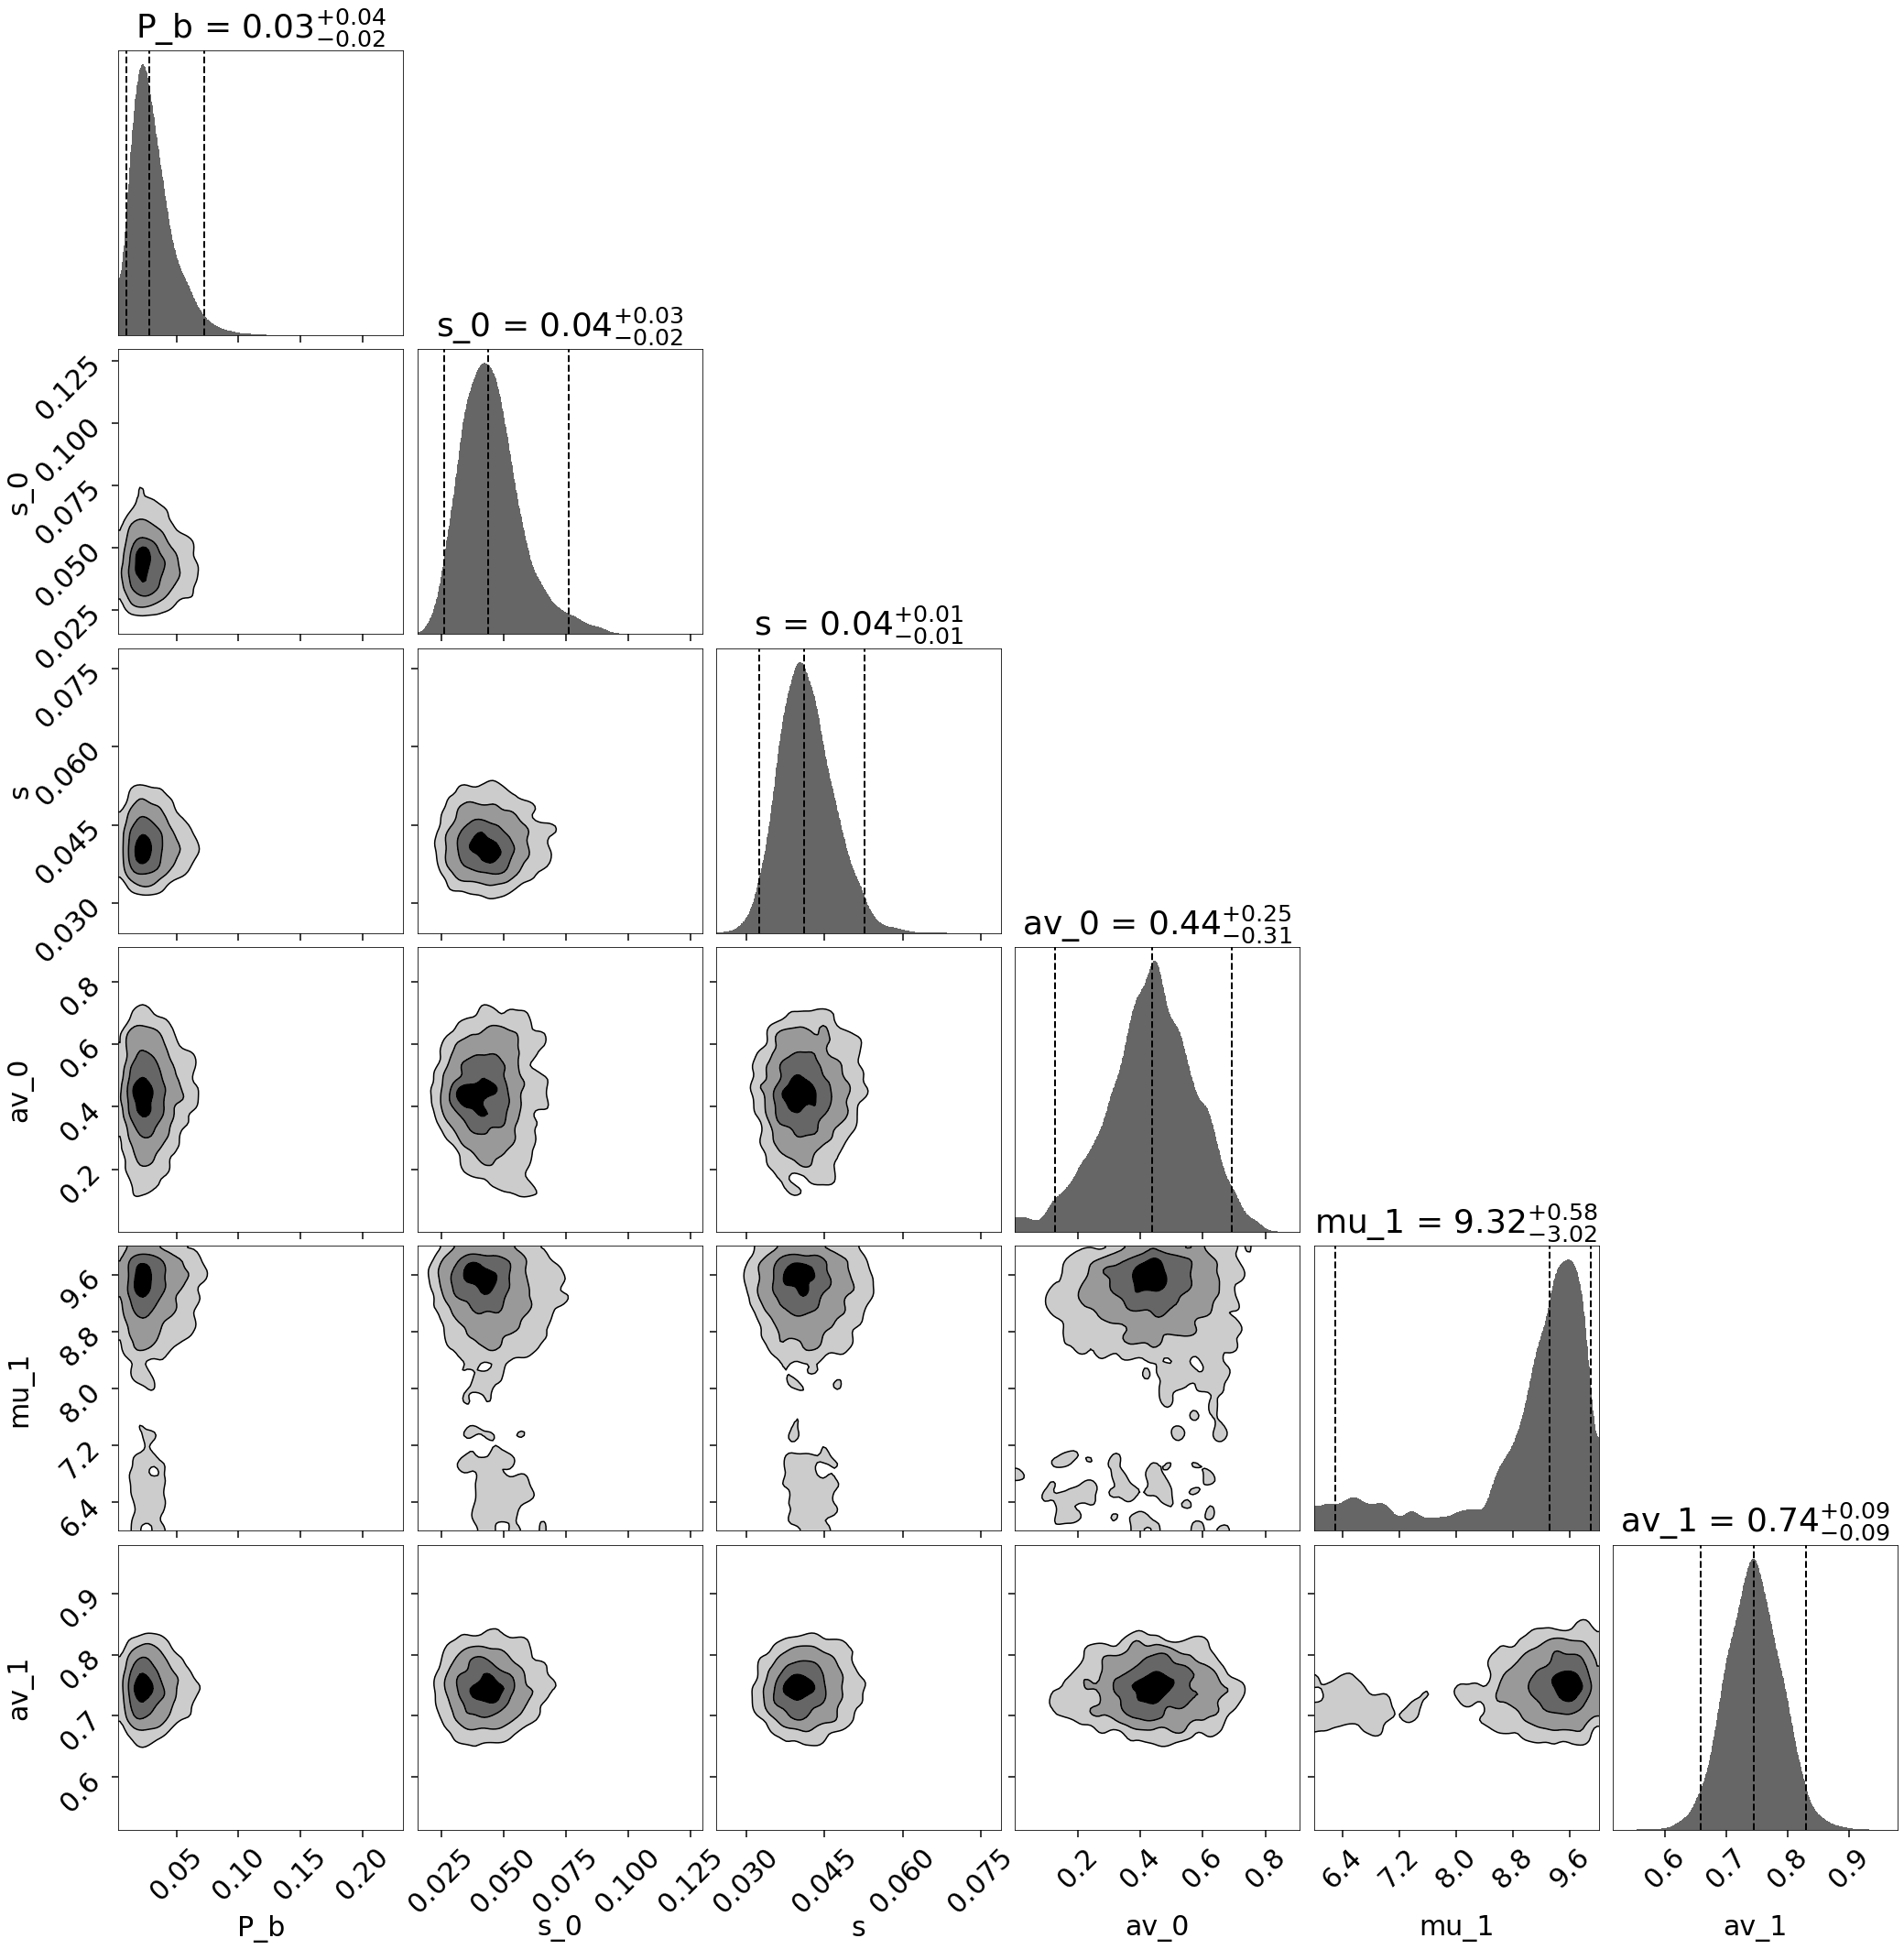

In [11]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(res, 
                            labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True,
                            fig=plt.subplots(6, 6, figsize=(30, 30)))

As expected, we don't have the strongest constraints on the distance to this particular "cloud" with only a handful of sources.